In [189]:
import os
import torch
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np

def load_model(model_dir, checkpoint_name, model_class):
    """
    Load the trained model and its config for inference.

    Args:
        model_dir (str): Base directory where models are saved (e.g., "trained_models/unet3d/Task08_HepaticVessel").
        checkpoint_name (str): The exact timestamped folder (e.g., "2025-03-07_01-52-17").
        model_class: The model architecture class (e.g., UNet3D).

    Returns:
        Tuple (model, cfg) - The loaded PyTorch model and its corresponding config.
    """
    checkpoint_path = os.path.join(model_dir, checkpoint_name)
    model_path = os.path.join(checkpoint_path, "model.pth")
    config_path = os.path.join(checkpoint_path, "config.yaml")

    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    assert os.path.exists(config_path), f"Config file not found: {config_path}"

    print(f"Loading model from: {model_path}")
    print(f"Loading config from: {config_path}")

    # Load the saved config
    cfg = OmegaConf.load(config_path)

    # Initialize the model using the stored config
    model = model_class(
        in_channels=1,
        num_classes=cfg.training.num_classes,
        n_filters=cfg.training.n_filters,
        dropout=cfg.training.dropout,
        batch_norm=True,
    )

    # Load the saved weights
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()  # Set to evaluation mode

    return model, cfg

def visualize_predictions(cfg, model, dataset, device, slice_idx=24, num_samples=3):
    """
    Visualize predictions for random samples from the dataset
    - model: trained model
    - dataset: HepaticVesselDataset instance
    - slice_idx: which depth slice to visualize
    - num_samples: number of samples to display
    """
    num_samples = min(num_samples, len(dataset))

    indices = np.random.choice(len(dataset), num_samples)
    
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)) 
            pred = torch.argmax(pred.squeeze(), dim=0)
            
        # Convert to numpy arrays
        image = image.squeeze().cpu().numpy() 
        label = label.cpu().numpy()
        pred = pred.squeeze().cpu().numpy()    
    

        slice_idx = min(slice_idx, image.shape[2] - 1)
        img_slice = image[:, :, slice_idx]
        label_slice = label[:, :, slice_idx]
        pred_slice = pred[:, :, slice_idx]
        
        # Plot
        axs[i, 0].imshow(img_slice, cmap='gray')
        axs[i, 0].set_title(f"Image {idx}")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(label_slice, cmap='jet', vmin=0, vmax=cfg.training.num_classes-1)
        # axs[i, 1].imshow(label_slice, cmap="jet")
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis('off')
        
        im = axs[i, 2].imshow(pred_slice, cmap='jet', vmin=0, vmax=cfg.training.num_classes-1)
        # im = axs[i, 2].imshow(pred_slice, cmap="jet")
        axs[i, 2].set_title("Prediction")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from typing import Tuple

def visualize_all_slices(
    image: np.ndarray, 
    ground_truth: np.ndarray, 
    prediction: np.ndarray, 
    grid_cols: int = 8,
    figsize: Tuple[int, int] = (16, 12)
) -> None:
    """
    Visualizes all slices of original image, ground truth, and prediction with consistent
    class coloring between ground truth and prediction.

    Args:
        image (np.ndarray): 3D array (H, W, D) of the original image
        ground_truth (np.ndarray): 3D array (H, W, D) of the ground truth mask
        prediction (np.ndarray): 3D array (H, W, D) of the predicted mask
        grid_cols (int): Number of columns in the visualization grid (default: 8)
        figsize (Tuple[int, int]): Figure size in inches (width, height) (default: (16, 12))
    """
    # Validate input dimensions
    assert image.shape == ground_truth.shape == prediction.shape, "All arrays must have same shape"
    height, width, num_slices = image.shape

    # Calculate rows needed per modality
    rows_per_modality = int(np.ceil(num_slices / grid_cols))
    total_rows = rows_per_modality * 3  # 3 modalities: Image, GT, Pred

    # Create figure with subplots
    fig, axes = plt.subplots(total_rows, grid_cols, figsize=figsize)
    fig.suptitle("Volume Visualization: Image, Ground Truth, and Prediction", 
                 fontsize=20, y=1.02)

    # Ensure axes is 2D even for single row
    if total_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    # Define a consistent colormap for segmentation classes
    class_colors = ['black', 'red', 'green', 'blue', 'yellow']
    num_classes = max(int(ground_truth.max()), int(prediction.max())) + 1
    if num_classes > len(class_colors):
        raise ValueError(f"Too many classes ({num_classes}). Max supported: {len(class_colors)}")
    segmentation_cmap = ListedColormap(class_colors[:num_classes])

    # Configuration for each modality (ensure correct order)
    modalities = [
        {"name": "Original Image", "data": image, "cmap": "gray", "title_color": "black"},
        {"name": "Ground Truth", "data": ground_truth, "cmap": segmentation_cmap, "title_color": "blue"},
        {"name": "Prediction", "data": prediction, "cmap": segmentation_cmap, "title_color": "red"}
    ]

    # Plot each modality
    for mod_idx, modality in enumerate(modalities):
        start_row = mod_idx * rows_per_modality
        
        # Add modality title on the left
        if rows_per_modality > 0:
            # Adjust the y-coordinate to align with the content
            title_y = 1 - (start_row + rows_per_modality / 2) / total_rows
            fig.text(0.01, 
                     title_y,
                     modality["name"],
                     va="center", 
                     ha="left",
                     fontsize=16,
                     fontweight="bold",
                     color=modality["title_color"],
                     rotation=90)

        # Plot slices
        for slice_idx in range(num_slices):
            row = start_row + (slice_idx // grid_cols)
            col = slice_idx % grid_cols
            
            ax = axes[row, col]
            if modality["name"] == "Original Image":
                ax.imshow(modality["data"][:, :, slice_idx], cmap=modality["cmap"])
            else:
                ax.imshow(modality["data"][:, :, slice_idx], 
                         cmap=modality["cmap"], 
                         vmin=0, 
                         vmax=num_classes-1)
            ax.set_axis_off()
            
            # Add slice number in top-left corner
            ax.text(0.05, 0.95, f"Slice {slice_idx}", 
                   transform=ax.transAxes, 
                   fontsize=8, 
                   color="white",
                   bbox=dict(facecolor="black", alpha=0.4))

        # Turn off unused axes
        for slice_idx in range(num_slices, rows_per_modality * grid_cols):
            row = start_row + (slice_idx // grid_cols)
            col = slice_idx % grid_cols
            axes[row, col].set_axis_off()

    # Add a colorbar for segmentation classes
    if num_classes > 1:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=segmentation_cmap, 
                            norm=plt.Normalize(vmin=0, vmax=num_classes-1)), 
                            cax=cbar_ax)
        cbar.set_ticks(range(num_classes))
        cbar.set_label("Class", fontsize=12)

    plt.tight_layout(rect=[0.03, 0, 0.9, 1])  # Adjust for colorbar and labels
    plt.show()

In [190]:
import torch
import os
from models.unet3d import UNet3D
from data.datasets import MedicalDecathlonDataset

# Manually specify the task and checkpoint timestamp
task_name = "Task04_Hippocampus"
checkpoint_name = "2025-03-07_23-56-48-[0.0483L]"

# Define model directory
model_dir = f"trained_models/unet3d/{task_name}"

# Load the trained model and its corresponding config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, cfg = load_model(model_dir, checkpoint_name, UNet3D)
model.to(device)

# Load dataset using the model's saved config
dataset_path = os.path.join(cfg.dataset.base_path, cfg.dataset.task_name)
images_path = os.path.join(dataset_path, cfg.dataset.images_subdir)
labels_path = os.path.join(dataset_path, cfg.dataset.labels_subdir)

dataset = MedicalDecathlonDataset(cfg, cfg.dataset.task_name, images_path, labels_path, cfg.dataset.target_shape)

Loading model from: trained_models/unet3d/Task04_Hippocampus/2025-03-07_23-56-48-[0.0483L]/model.pth
Loading config from: trained_models/unet3d/Task04_Hippocampus/2025-03-07_23-56-48-[0.0483L]/config.yaml


Loaded image tensor with shape: torch.Size([1, 48, 64, 48])
Removed batch dimension, new shape: torch.Size([48, 64, 48])


/tmp/ipykernel_423708/940531120.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0, 0.9, 1])  # Adjust for colorbar and labels


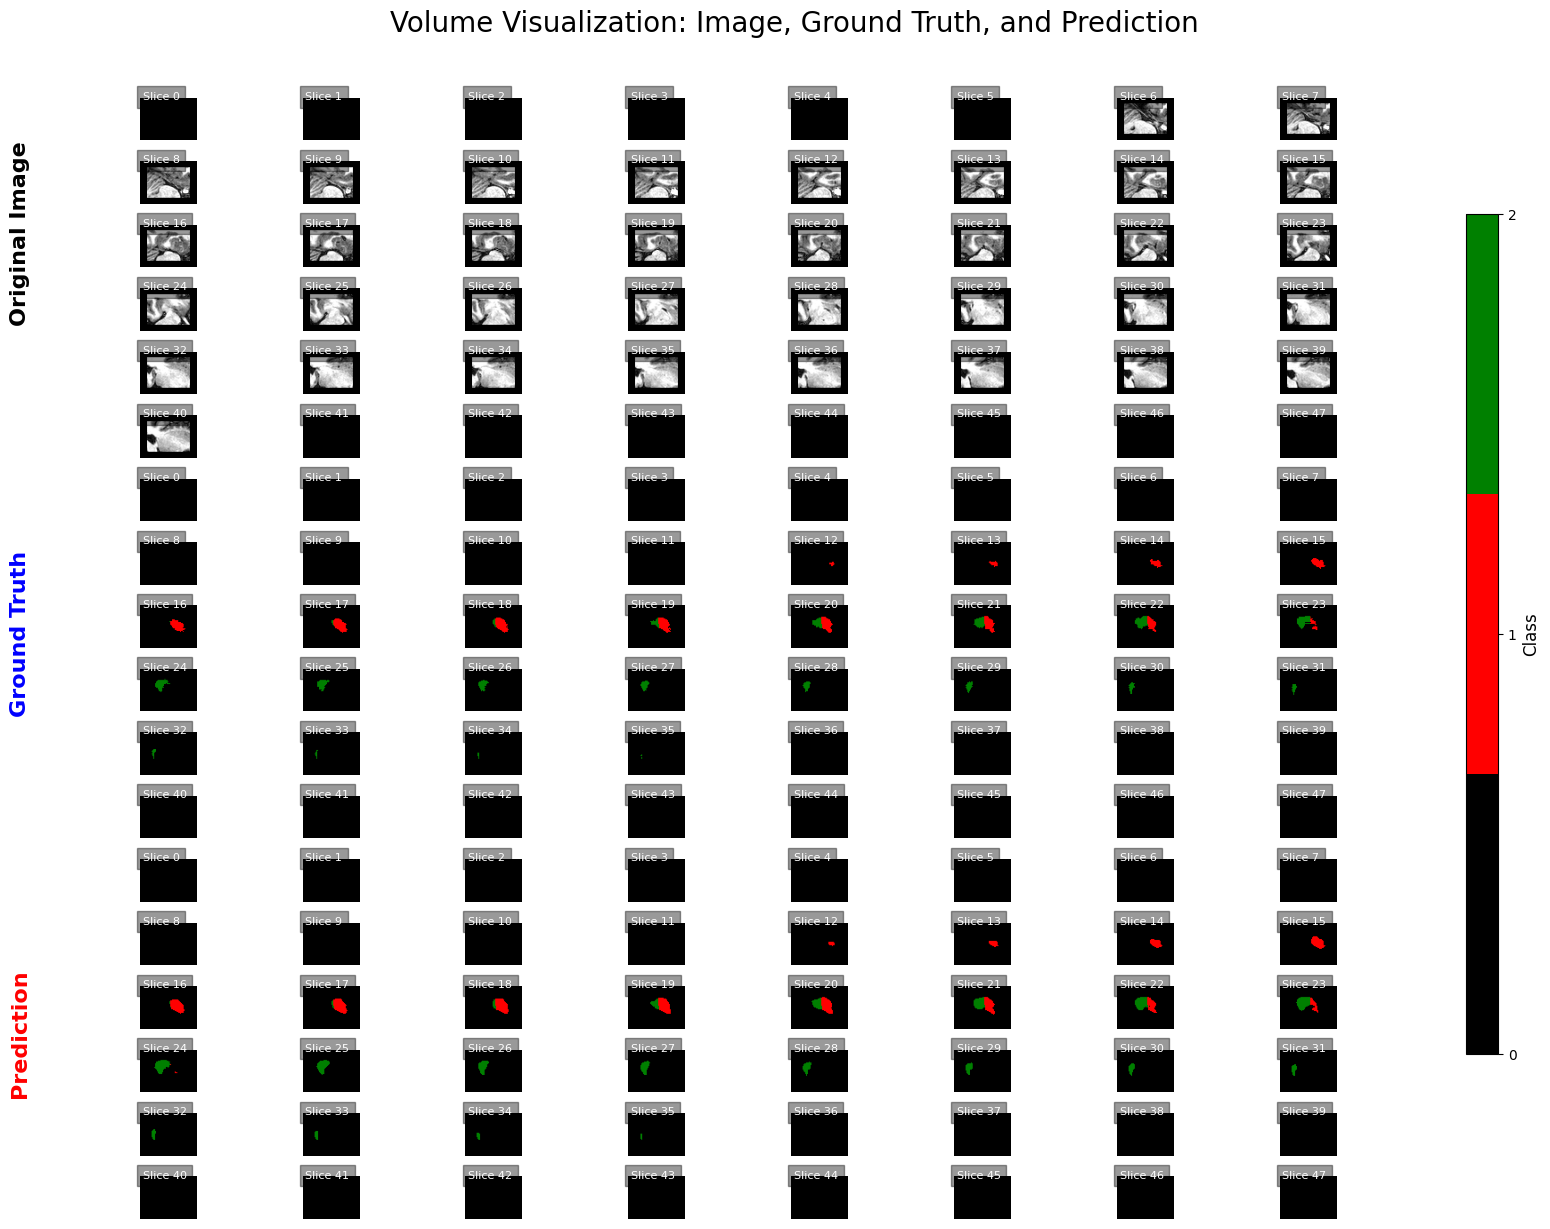

In [191]:
index = np.random.randint(0, len(dataset) - 1)
image_tensor, label_tensor = dataset[index]  # image_tensor: torch.Size([1, 48, 64, 48])
print(f"Loaded image tensor with shape: {image_tensor.shape}")

# Remove batch dimension
image_tensor = image_tensor.squeeze(0)  # Now shape: (48, 64, 48)
print(f"Removed batch dimension, new shape: {image_tensor.shape}")
label_tensor = label_tensor.squeeze(0)  # Adjust label similarly if needed


# Run model inference using the tensor
with torch.no_grad():
    # Add a batch dimension back for the model, run inference
    pred_tensor = model(image_tensor.unsqueeze(0).unsqueeze(0).to(device))
    # Assume model outputs logits: squeeze batch and choose class with highest score
    pred_tensor = torch.argmax(pred_tensor.squeeze(), dim=0)

# Convert tensors to numpy arrays for visualization
image = image_tensor.cpu().numpy()
label = label_tensor.cpu().numpy()
pred = pred_tensor.cpu().numpy()

# Visualize image, ground truth and prediction
visualize_all_slices(image, label, pred)


Image min/max: 0.0000/1.0000
Label unique values: tensor([0, 1, 2])


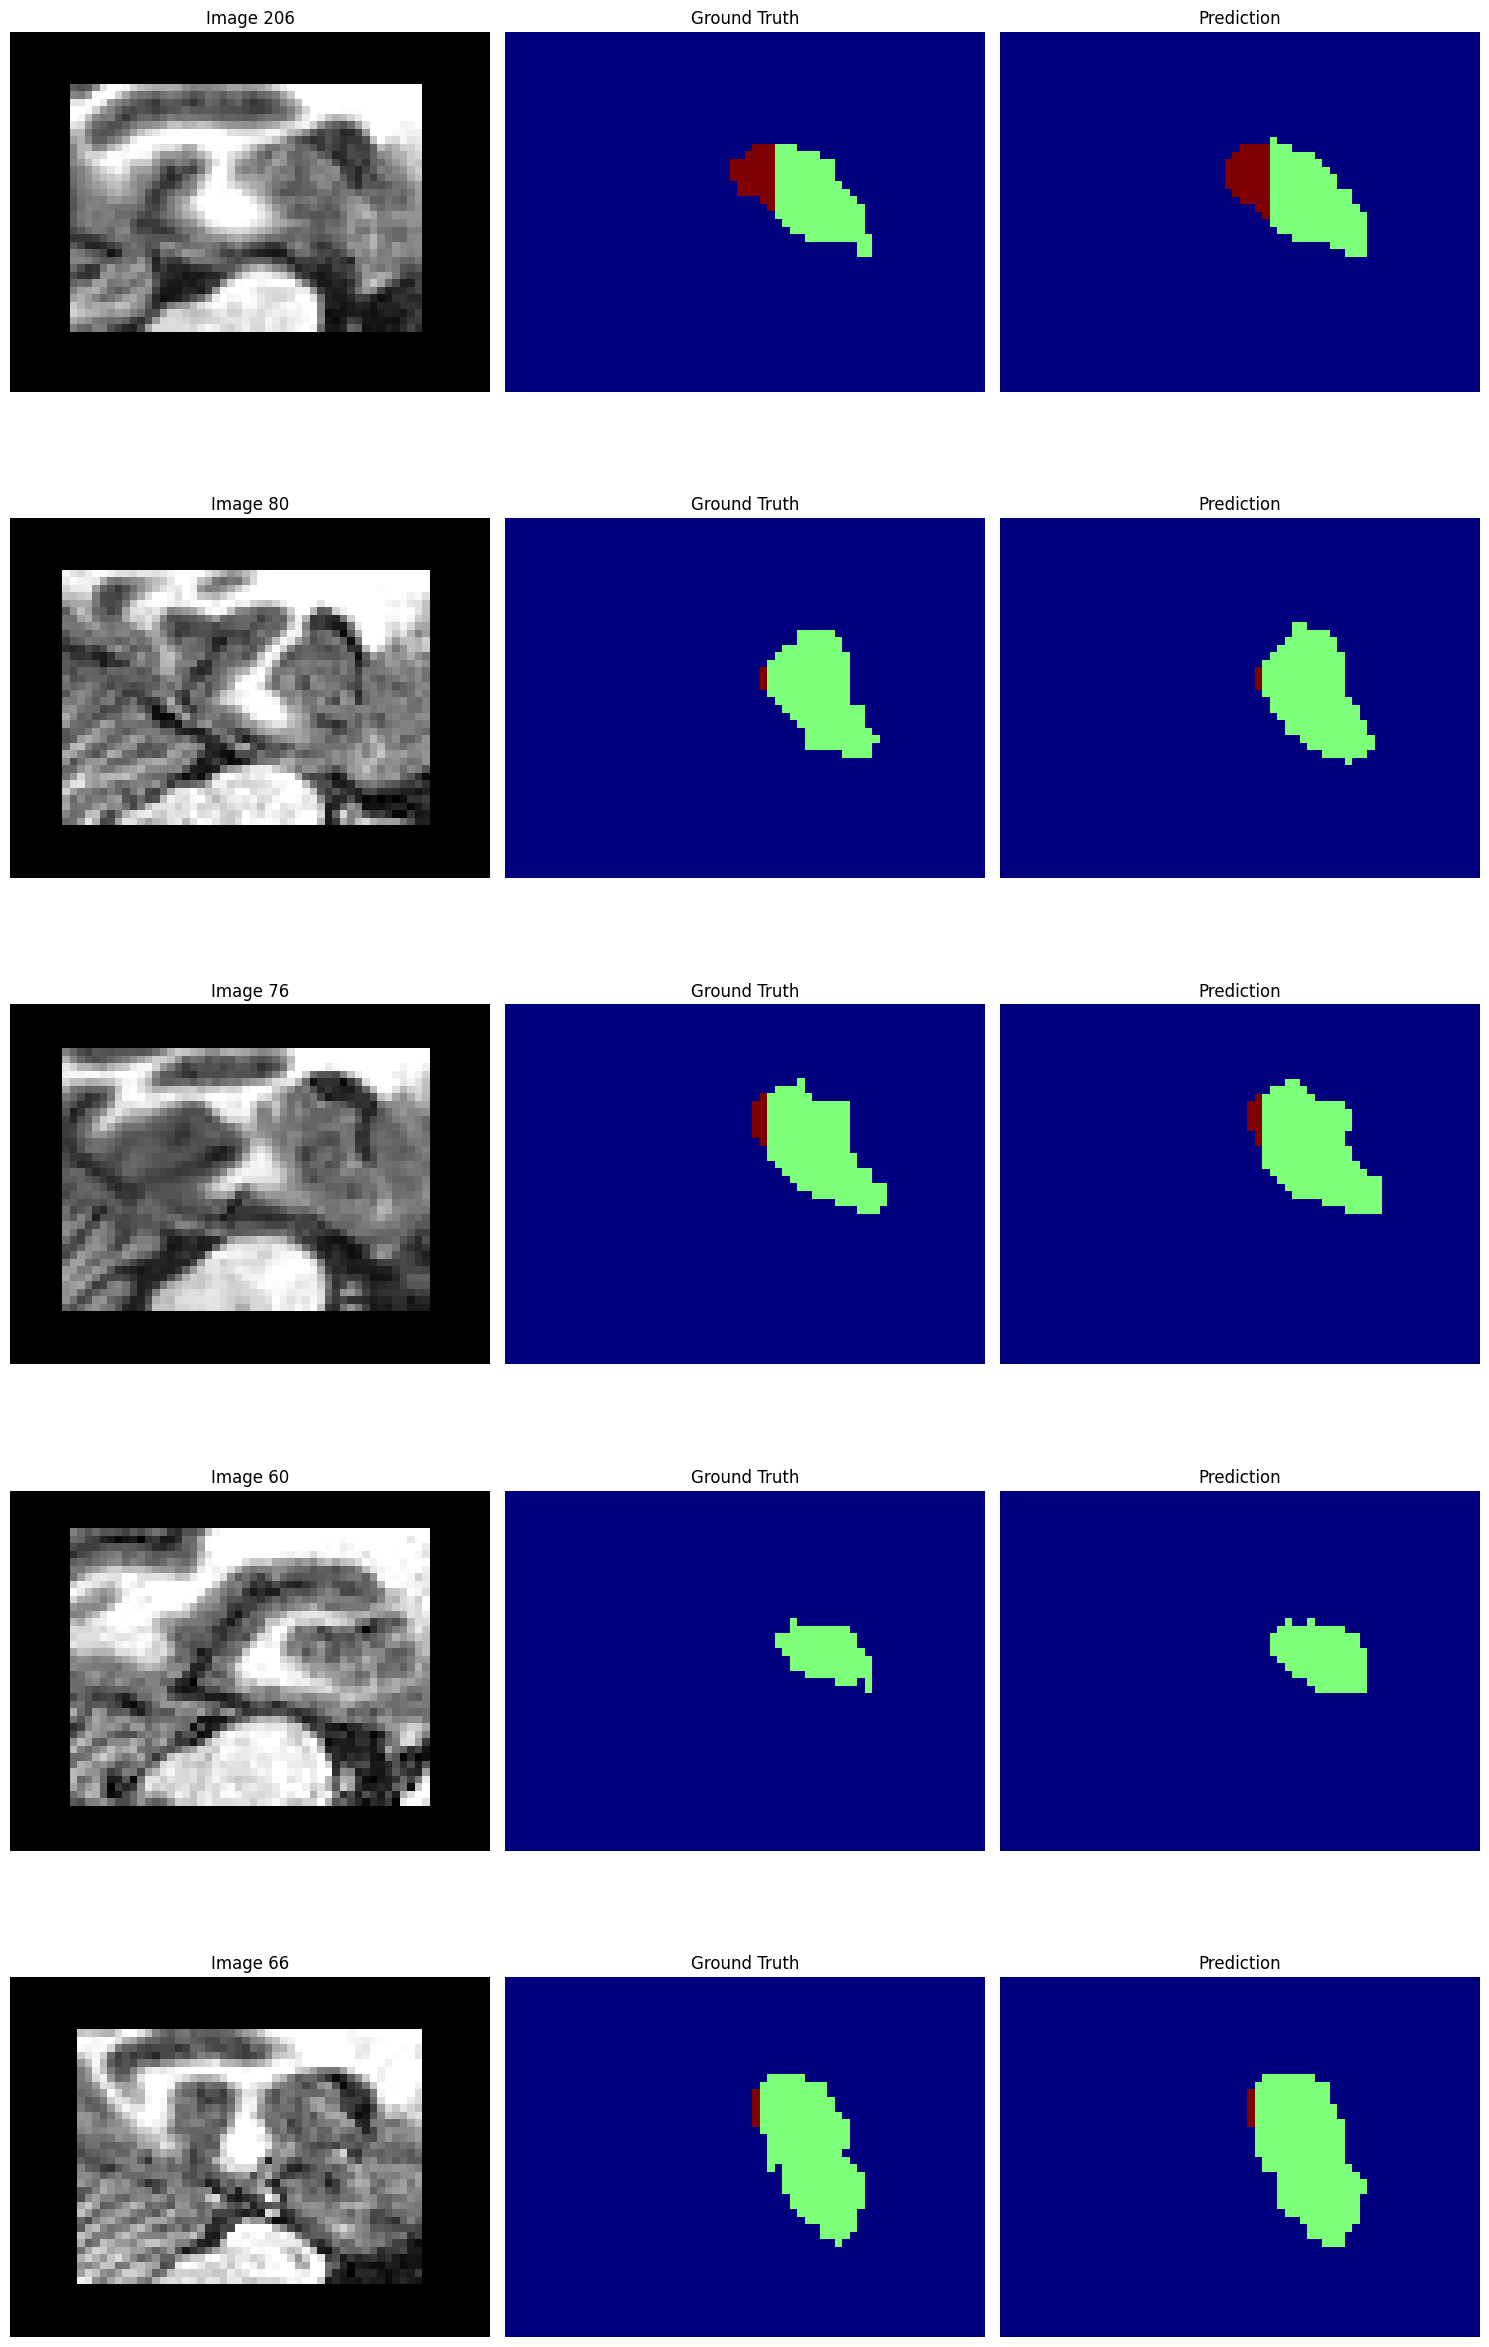

In [192]:
image, label = dataset[0]
print(f"Image min/max: {image.min():.4f}/{image.max():.4f}")
print(f"Label unique values: {torch.unique(label)}")


visualize_predictions(cfg, model, dataset, device, 15, 5)